In [1]:
import pandas as pd
import numpy as np

# Load custom modules
from nets import *
from sampling import *
from preprocess import *
from model_data import *
from model import *
from metrics import gini_normalized

# Others
from tqdm import tqdm
from torch.autograd import Variable as V
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import sys

In [29]:
sys.path.append('../../../Desktop/FASTAI/fastai/')

In [30]:
from fastai.learner import *

In [31]:
from fastai.column_data import *

In [64]:
from torch.utils.data import Dataset, DataLoader

### LOAD DATA

For fast iterations and experimentaions we will work with a random subsample.

In [2]:
train = pd.read_csv('./data/Porto_Seguro/train.csv')

In [3]:
train.shape

(595212, 59)

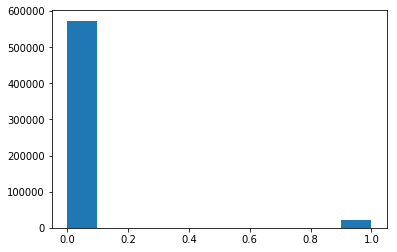

In [4]:
plot = plt.hist(train.target)

In [5]:
sampledata = subsample(train, 0.25)

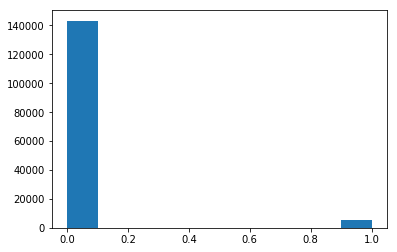

In [6]:
plot = plt.hist(sampledata.target)

In [7]:
# Get ohe for cats
cats = [c for c in sampledata.columns if 'cat' in c]
sampledata = num_df(sampledata, cats)

In [8]:
sampledata.shape

(148803, 243)

In [9]:
# drop calc features
calcs = [c for c in sampledata.columns if 'calc' in c]

In [10]:
sampledata = sampledata.drop(calcs, 1)

### SIMPLENET

* Simple Fully Connected Net
* OHE data 
* Normalized data 

In [11]:
# Normalize data by rankgauss, ignore id and target
sampledata = rankgauss(sampledata, exclude=['id', 'target'])

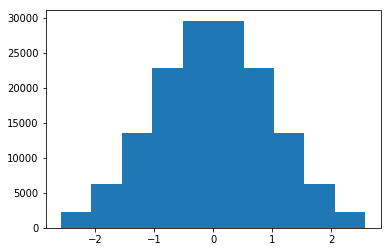

In [12]:
plot = plt.hist(sampledata.ps_car_01_cat)

### FASTAI INTERGRATION

* Need learner for lr_find
* Need trn_dl, val_dl for learner
* Need ModelData for trn_dl, val_dl
* Have a training function which creates modeldata and learner for each cv_idxs.

**IMPORTANT NOTE**: NLLLoss expects dimensionless output so in our data set instead of returning y as a Tensor we are returning the value inside.

Here we used a subsample of our data to find the best lr 

In [54]:
# Do 5 fold cv split
cv = kfold_cv_idx(sampledata, 5)

In [425]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for o in self.linears: kaiming_normal(o.weight.data)
            
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x, dim=1)

In [112]:
class SimpleColumnDataset(Dataset):
    # Expecting a numpy array
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return torch.from_numpy(self.X[index]).float(), torch.from_numpy(self.y[index, None])[0]

    def __len__(self):
        return len(self.y)

In [503]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 646/931 [00:06<00:02, 103.94it/s, loss=0.633]


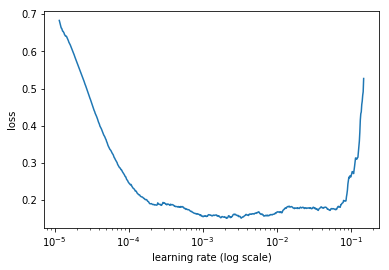

In [432]:
learn.sched.plot()

In [521]:
lr = 1e-4

In [522]:
learn.fit(lr, 5, wds=1e-4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.16248  0.16311]                                  
[ 1.       0.15261  0.15985]                                  
[ 2.       0.14559  0.15787]                                  
[ 3.       0.15333  0.15744]                                  
[ 4.       0.17546  0.15712]                                  



In [534]:
learn.fit(lr, 1, wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.14637  0.15665]                                  



In [535]:
preds = learn.predict()
preds = np.exp(preds)[:, 1]
gini_normalized(y[val_idx], preds)

In [550]:
# INPUT
X, y = sampledata.drop(['id', 'target'], 1), sampledata.target
X, y = np.array(X), np.array(y)
cv_idxs = cv
lr = 1e-4

# results
cv_res = []

for trn_idx, val_idx in cv_idxs:
    
    # Create model data
    trn_ds = SimpleColumnDataset(X[trn_idx], y[trn_idx])
    val_ds = SimpleColumnDataset(X[val_idx], y[val_idx])
    trn_dl = DataLoader(trn_ds, 128, True)
    val_dl = DataLoader(val_ds, 128)

    # Fastai integration
    md = ModelData('./', trn_dl, val_dl)
    model = SingleModel(SimpleNet([221, 1000, 2]))
    learn = Learner(md, model)
    learn.crit = nn.NLLLoss()
    learn.opt_fn = optim.Adam
    
    # Fit model
    learn.fit(lr, 10, wds=1e-4, cycle_len=1)
    
    # Get cv results
    preds = learn.predict()
    preds = np.exp(preds)[:, 1]
    gini_score = gini_normalized(y[val_idx], preds)
    cv_res.append(gini_score)
    
print(f'Gini mean: {round(np.mean(cv_res), 4)} +/- {round(np.std(cv_res), 4)}')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


 12%|█▏        | 115/931 [00:01<00:09, 81.92it/s, loss=0.31]


 24%|██▍       | 223/931 [00:02<00:08, 83.57it/s, loss=0.172]


 36%|███▌      | 336/931 [00:03<00:07, 84.36it/s, loss=0.163]


 48%|████▊     | 451/931 [00:05<00:05, 82.69it/s, loss=0.159]


 60%|██████    | 561/931 [00:06<00:04, 83.06it/s, loss=0.159]


 74%|███████▎  | 685/931 [00:07<00:02, 85.85it/s, loss=0.163]


 86%|████████▌ | 798/931 [00:09<00:01, 85.43it/s, loss=0.166]


 98%|█████████▊| 908/931 [00:10<00:00, 85.15it/s, loss=0.152]


100%|█████████▉| 927/931 [00:10<00:00, 85.31it/s, loss=0.148]
                                                             [ 0.       0.14757  0.16127]

 10%|▉         | 90/931 [00:01<00:09, 86.18it/s, loss=0.151]


 22%|██▏       | 206/931 [00:02<00:08, 84.78it/s, loss=0.165]


 35%|███▍      | 324/931 [00:03<00:07, 84.82it/s, loss=0.165]


 47%|████▋     | 435/931 [00:05<00:06, 81.36it/s, loss=0.16] 


 59%|█████▉    | 547/931 [00:06<00:04, 82.06it/s, loss=0.155]


 71%|███████   | 661/931 [00:08<00:03, 81.64it/s, loss=0.152]


 83%|████████▎ | 773/931 [00:09<00:01, 81.09it/s, loss=0.16] 


 96%|█████████▌| 893/931 [00:10<00:00, 81.72it/s, loss=0.156]


100%|█████████▉| 929/931 [00:11<00:00, 81.29it/s, loss=0.147]
                                                             [ 1.       0.14737  0.15907]

  8%|▊         | 75/931 [00:00<00:09, 87.84it/s, loss=0.155]


 20%|██        | 187/931 [00:02<00:08, 83.40it/s, loss=0.154]


 32%|███▏      | 299/931 [00:03<00:07, 83.94it/s, loss=0.151]


 44%|████▍     | 409/931 [00:04<00:06, 81.99it/s, loss=0.155]


 56%|█████▋    | 525/931 [00:06<00:04, 82.17it/s, loss=0.156]


 69%|██████▉   | 642/931 [00:07<00:03, 82.76it/s, loss=0.157]


 81%|████████  | 756/931 [00:09<00:02, 83.00it/s, loss=0.148]


 93%|█████████▎| 864/931 [00:10<00:00, 82.16it/s, loss=0.165]


100%|██████████| 931/931 [00:11<00:00, 83.20it/s, loss=0.153]
                                                             [ 2.       0.15255  0.15793]

  5%|▌         | 49/931 [00:00<00:12, 70.99it/s, loss=0.159]


 18%|█▊        | 164/931 [00:02<00:09, 79.57it/s, loss=0.151]


 30%|██▉       | 276/931 [00:03<00:08, 81.35it/s, loss=0.154]


 41%|████▏     | 386/931 [00:04<00:06, 81.22it/s, loss=0.149]


 55%|█████▍    | 508/931 [00:06<00:05, 83.24it/s, loss=0.158]


 67%|██████▋   | 622/931 [00:07<00:03, 83.28it/s, loss=0.151]


 79%|███████▉  | 734/931 [00:08<00:02, 82.90it/s, loss=0.151]


 91%|█████████ | 849/931 [00:10<00:00, 83.31it/s, loss=0.152]


 99%|█████████▉| 923/931 [00:11<00:00, 82.21it/s, loss=0.153]
                                                             [ 3.       0.15299  0.15743]

  3%|▎         | 28/931 [00:00<00:12, 72.51it/s, loss=0.151]


 15%|█▌        | 142/931 [00:01<00:10, 74.38it/s, loss=0.162]


 28%|██▊       | 258/931 [00:03<00:08, 78.02it/s, loss=0.165]


 40%|███▉      | 368/931 [00:04<00:07, 78.59it/s, loss=0.154]


 52%|█████▏    | 484/931 [00:06<00:05, 78.39it/s, loss=0.146]


 64%|██████▎   | 593/931 [00:07<00:04, 77.44it/s, loss=0.148]


 76%|███████▌  | 708/931 [00:09<00:02, 75.91it/s, loss=0.158]


 88%|████████▊ | 818/931 [00:10<00:01, 76.36it/s, loss=0.148]


100%|██████████| 931/931 [00:12<00:00, 77.48it/s, loss=0.151]
                                                             [ 4.       0.15065  0.15728]

  1%|          | 7/931 [00:00<00:16, 54.68it/s, loss=0.154]


 12%|█▏        | 112/931 [00:02<00:16, 50.43it/s, loss=0.152]


 24%|██▍       | 227/931 [00:03<00:11, 60.18it/s, loss=0.151]


 37%|███▋      | 343/931 [00:05<00:08, 67.68it/s, loss=0.153]


 49%|████▉     | 455/931 [00:06<00:06, 70.38it/s, loss=0.15] 


 61%|██████    | 564/931 [00:07<00:05, 71.88it/s, loss=0.155]


 73%|███████▎  | 682/931 [00:09<00:03, 74.39it/s, loss=0.163]


 86%|████████▌ | 797/931 [00:10<00:01, 76.20it/s, loss=0.152]


 98%|█████████▊| 912/931 [00:11<00:00, 76.58it/s, loss=0.141]


100%|█████████▉| 928/931 [00:12<00:00, 76.34it/s, loss=0.148]
                                                             [ 5.       0.14757  0.15726]

 10%|▉         | 89/931 [00:01<00:10, 77.95it/s, loss=0.146]


 22%|██▏       | 208/931 [00:02<00:08, 82.49it/s, loss=0.146]


 34%|███▍      | 318/931 [00:03<00:07, 80.93it/s, loss=0.146]


 47%|████▋     | 435/931 [00:05<00:06, 80.81it/s, loss=0.156]


 58%|█████▊    | 543/931 [00:06<00:04, 80.68it/s, loss=0.15] 


 71%|███████   | 660/931 [00:08<00:03, 82.09it/s, loss=0.147]


 83%|████████▎ | 770/931 [00:09<00:01, 81.64it/s, loss=0.161]


 95%|█████████▍| 881/931 [00:10<00:00, 81.81it/s, loss=0.159]


 99%|█████████▉| 923/931 [00:11<00:00, 82.51it/s, loss=0.181]
                                                             [ 6.       0.18141  0.15725]

  7%|▋         | 68/931 [00:00<00:10, 83.71it/s, loss=0.158]


 20%|██        | 187/931 [00:02<00:08, 88.20it/s, loss=0.148]


 32%|███▏      | 302/931 [00:03<00:07, 85.90it/s, loss=0.157]


 44%|████▍     | 413/931 [00:04<00:06, 84.89it/s, loss=0.154]


 57%|█████▋    | 527/931 [00:06<00:04, 84.62it/s, loss=0.149]


 69%|██████▊   | 639/931 [00:07<00:03, 83.29it/s, loss=0.151]


 81%|████████  | 755/931 [00:09<00:02, 82.88it/s, loss=0.161]


 93%|█████████▎| 862/931 [00:10<00:00, 81.31it/s, loss=0.153]


 99%|█████████▉| 925/931 [00:11<00:00, 81.61it/s, loss=0.149]
                                                             [ 7.       0.14893  0.157  ]

  5%|▌         | 50/931 [00:00<00:11, 73.85it/s, loss=0.141]


 17%|█▋        | 161/931 [00:02<00:11, 69.65it/s, loss=0.15]


 29%|██▉       | 270/931 [00:03<00:09, 71.27it/s, loss=0.156]


 41%|████▏     | 385/931 [00:05<00:07, 72.65it/s, loss=0.142]


 53%|█████▎    | 497/931 [00:06<00:05, 72.49it/s, loss=0.156]


 66%|██████▌   | 616/931 [00:08<00:04, 74.18it/s, loss=0.153]


 78%|███████▊  | 724/931 [00:09<00:02, 73.69it/s, loss=0.157]


 90%|█████████ | 839/931 [00:11<00:01, 74.85it/s, loss=0.148]


100%|█████████▉| 929/931 [00:12<00:00, 75.24it/s, loss=0.157]
                                                             [ 8.       0.1573   0.15692]

  2%|▏         | 16/931 [00:00<00:18, 49.46it/s, loss=0.157]


 15%|█▍        | 136/931 [00:01<00:10, 76.35it/s, loss=0.154]


 27%|██▋       | 248/931 [00:03<00:08, 76.83it/s, loss=0.156]


 39%|███▉      | 362/931 [00:04<00:07, 77.72it/s, loss=0.156]


 51%|█████     | 475/931 [00:06<00:05, 77.91it/s, loss=0.147]


 63%|██████▎   | 584/931 [00:07<00:04, 79.33it/s, loss=0.158]


 76%|███████▌  | 704/931 [00:08<00:02, 81.70it/s, loss=0.158]


 88%|████████▊ | 815/931 [00:10<00:01, 81.22it/s, loss=0.151]


 99%|█████████▉| 926/931 [00:11<00:00, 80.38it/s, loss=0.142]


                                                             [ 9.       0.14182  0.15695]



HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


 12%|█▏        | 114/931 [00:01<00:09, 88.67it/s, loss=0.283]


 24%|██▍       | 223/931 [00:02<00:09, 78.51it/s, loss=0.182]


 36%|███▌      | 337/931 [00:04<00:07, 77.10it/s, loss=0.162]


 49%|████▊     | 452/931 [00:05<00:06, 78.21it/s, loss=0.16] 


 60%|██████    | 562/931 [00:07<00:04, 78.41it/s, loss=0.156]


 73%|███████▎  | 680/931 [00:08<00:03, 79.37it/s, loss=0.163]


 85%|████████▌ | 792/931 [00:09<00:01, 80.22it/s, loss=0.149]


 97%|█████████▋| 903/931 [00:11<00:00, 80.47it/s, loss=0.155]


100%|█████████▉| 929/931 [00:11<00:00, 80.62it/s, loss=0.153]
                                                             [ 0.       0.15334  0.15815]

  9%|▉         | 84/931 [00:01<00:10, 80.71it/s, loss=0.15] 


 22%|██▏       | 203/931 [00:02<00:08, 83.87it/s, loss=0.164]


 34%|███▍      | 318/931 [00:03<00:07, 82.60it/s, loss=0.155]


 46%|████▋     | 431/931 [00:05<00:06, 81.02it/s, loss=0.156]


 58%|█████▊    | 540/931 [00:06<00:04, 79.95it/s, loss=0.152]


 70%|██████▉   | 651/931 [00:08<00:03, 78.78it/s, loss=0.155]


 82%|████████▏ | 764/931 [00:09<00:02, 77.33it/s, loss=0.159]


 95%|█████████▍| 880/931 [00:11<00:00, 77.50it/s, loss=0.153]


100%|█████████▉| 929/931 [00:12<00:00, 77.28it/s, loss=0.153]
                                                             [ 1.       0.15291  0.15613]

  7%|▋         | 63/931 [00:00<00:10, 83.38it/s, loss=0.159]


 18%|█▊        | 170/931 [00:02<00:10, 75.19it/s, loss=0.16]


 31%|███       | 287/931 [00:03<00:07, 84.18it/s, loss=0.163]


 44%|████▎     | 407/931 [00:04<00:05, 88.95it/s, loss=0.151]


 55%|█████▌    | 516/931 [00:05<00:04, 87.57it/s, loss=0.155]


 67%|██████▋   | 627/931 [00:07<00:03, 84.87it/s, loss=0.149]


 80%|███████▉  | 744/931 [00:09<00:02, 82.44it/s, loss=0.155]


 92%|█████████▏| 856/931 [00:10<00:00, 81.59it/s, loss=0.145]


 99%|█████████▉| 924/931 [00:11<00:00, 81.35it/s, loss=0.187]
                                                             [ 2.       0.18664  0.15579]

  4%|▍         | 41/931 [00:00<00:09, 90.01it/s, loss=0.176]


 17%|█▋        | 158/931 [00:01<00:08, 91.24it/s, loss=0.152]


 29%|██▊       | 267/931 [00:03<00:07, 84.46it/s, loss=0.148]


 41%|████▏     | 385/931 [00:04<00:06, 86.61it/s, loss=0.158]


 53%|█████▎    | 492/931 [00:05<00:05, 83.29it/s, loss=0.162]


 66%|██████▌   | 612/931 [00:07<00:03, 83.14it/s, loss=0.146]


 78%|███████▊  | 722/931 [00:08<00:02, 82.98it/s, loss=0.143]


 89%|████████▉ | 833/931 [00:09<00:01, 83.80it/s, loss=0.158]


 99%|█████████▉| 926/931 [00:10<00:00, 86.12it/s, loss=0.155]
                                                             [ 3.       0.15528  0.15543]

  3%|▎         | 26/931 [00:00<00:07, 118.50it/s, loss=0.155]


 15%|█▍        | 139/931 [00:01<00:07, 107.10it/s, loss=0.158]


 26%|██▋       | 245/931 [00:02<00:07, 97.74it/s, loss=0.14] 


 40%|███▉      | 369/931 [00:03<00:05, 98.46it/s, loss=0.146]


 52%|█████▏    | 483/931 [00:05<00:04, 95.19it/s, loss=0.154]


 64%|██████▍   | 597/931 [00:06<00:03, 93.33it/s, loss=0.151]


 76%|███████▋  | 710/931 [00:07<00:02, 90.77it/s, loss=0.157]


 88%|████████▊ | 816/931 [00:09<00:01, 86.65it/s, loss=0.152]


100%|█████████▉| 929/931 [00:10<00:00, 84.97it/s, loss=0.154]
                                                             [ 4.       0.15368  0.15524]

  0%|          | 0/931 [00:00<?, ?it/s, loss=0.151]


 12%|█▏        | 114/931 [00:01<00:09, 86.51it/s, loss=0.155]


 25%|██▌       | 234/931 [00:02<00:07, 95.34it/s, loss=0.157]


 37%|███▋      | 342/931 [00:03<00:06, 94.02it/s, loss=0.153]


 50%|████▉     | 462/931 [00:04<00:04, 97.08it/s, loss=0.143]


 62%|██████▏   | 573/931 [00:05<00:03, 97.22it/s, loss=0.151]


 74%|███████▍  | 691/931 [00:07<00:02, 97.28it/s, loss=0.157]


 86%|████████▋ | 805/931 [00:08<00:01, 97.07it/s, loss=0.155]


 99%|█████████▉| 925/931 [00:09<00:00, 98.09it/s, loss=0.155]


 99%|█████████▉| 925/931 [00:09<00:00, 97.65it/s, loss=0.153]
                                                             [ 5.       0.15251  0.15517]

 11%|█▏        | 106/931 [00:01<00:09, 85.54it/s, loss=0.152]


 24%|██▎       | 221/931 [00:02<00:08, 87.65it/s, loss=0.151]


 36%|███▌      | 333/931 [00:03<00:06, 85.76it/s, loss=0.148]


 48%|████▊     | 444/931 [00:05<00:05, 86.78it/s, loss=0.165]


 61%|██████    | 566/931 [00:06<00:04, 86.67it/s, loss=0.16] 


 72%|███████▏  | 672/931 [00:07<00:03, 84.66it/s, loss=0.149]


 84%|████████▍ | 786/931 [00:09<00:01, 86.26it/s, loss=0.159]


 97%|█████████▋| 905/931 [00:10<00:00, 87.10it/s, loss=0.152]


 99%|█████████▉| 923/931 [00:10<00:00, 86.85it/s, loss=0.148]
                                                             [ 6.       0.14785  0.15527]

 10%|█         | 94/931 [00:00<00:08, 96.62it/s, loss=0.148]


 22%|██▏       | 205/931 [00:02<00:08, 89.35it/s, loss=0.162]


 34%|███▍      | 316/931 [00:03<00:06, 89.75it/s, loss=0.142]


 47%|████▋     | 433/931 [00:04<00:05, 92.63it/s, loss=0.153]


 59%|█████▉    | 553/931 [00:05<00:03, 94.95it/s, loss=0.152]


 71%|███████▏  | 665/931 [00:07<00:02, 94.69it/s, loss=0.147]


 84%|████████▎ | 779/931 [00:08<00:01, 94.80it/s, loss=0.151]


 96%|█████████▋| 897/931 [00:09<00:00, 93.85it/s, loss=0.154]


 99%|█████████▉| 924/931 [00:09<00:00, 92.53it/s, loss=0.155]
                                                             [ 7.       0.15498  0.15512]

  8%|▊         | 78/931 [00:00<00:09, 87.89it/s, loss=0.145]


 21%|██        | 193/931 [00:02<00:08, 82.87it/s, loss=0.15] 


 32%|███▏      | 299/931 [00:03<00:07, 86.31it/s, loss=0.147]


 46%|████▌     | 425/931 [00:04<00:05, 93.78it/s, loss=0.16]


 57%|█████▋    | 535/931 [00:05<00:04, 94.19it/s, loss=0.155]


 70%|██████▉   | 650/931 [00:06<00:02, 95.02it/s, loss=0.149]


 83%|████████▎ | 770/931 [00:07<00:01, 96.63it/s, loss=0.151]


 95%|█████████▍| 880/931 [00:09<00:00, 96.91it/s, loss=0.144]


 99%|█████████▉| 924/931 [00:09<00:00, 96.18it/s, loss=0.15] 
                                                            [ 8.       0.14952  0.15528]

  7%|▋         | 66/931 [00:00<00:09, 95.69it/s, loss=0.158]


 19%|█▉        | 181/931 [00:02<00:08, 88.90it/s, loss=0.148]


 31%|███▏      | 293/931 [00:03<00:07, 89.92it/s, loss=0.15] 


 44%|████▎     | 406/931 [00:04<00:05, 91.05it/s, loss=0.146]


 56%|█████▌    | 523/931 [00:05<00:04, 93.43it/s, loss=0.153]


 69%|██████▉   | 644/931 [00:06<00:03, 93.83it/s, loss=0.152]


 81%|████████  | 754/931 [00:08<00:01, 93.02it/s, loss=0.15]


 93%|█████████▎| 867/931 [00:09<00:00, 91.97it/s, loss=0.151]


 99%|█████████▉| 924/931 [00:10<00:00, 91.72it/s, loss=0.144]
                                                             [ 9.       0.144    0.15538]



HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


 12%|█▏        | 111/931 [00:01<00:08, 91.74it/s, loss=0.266]


 24%|██▍       | 225/931 [00:02<00:07, 90.51it/s, loss=0.173]


 37%|███▋      | 341/931 [00:03<00:06, 91.11it/s, loss=0.158]


 49%|████▉     | 460/931 [00:04<00:04, 94.21it/s, loss=0.157]


 62%|██████▏   | 573/931 [00:05<00:03, 95.93it/s, loss=0.156]


 74%|███████▍  | 688/931 [00:07<00:02, 97.74it/s, loss=0.16] 


 86%|████████▌ | 800/931 [00:08<00:01, 98.27it/s, loss=0.157]


 98%|█████████▊| 914/931 [00:09<00:00, 97.47it/s, loss=0.154]


 99%|█████████▉| 925/931 [00:09<00:00, 98.05it/s, loss=0.154]
                                                             [ 0.       0.15389  0.1565 ]

 11%|█         | 101/931 [00:01<00:08, 99.67it/s, loss=0.158] 


 24%|██▎       | 221/931 [00:02<00:07, 101.17it/s, loss=0.167]


 36%|███▌      | 332/931 [00:03<00:06, 93.93it/s, loss=0.153]


 48%|████▊     | 448/931 [00:04<00:05, 90.86it/s, loss=0.157]


 60%|█████▉    | 554/931 [00:06<00:04, 87.52it/s, loss=0.165]


 72%|███████▏  | 668/931 [00:07<00:03, 85.09it/s, loss=0.155]


 84%|████████▍ | 783/931 [00:09<00:01, 83.27it/s, loss=0.156]


 97%|█████████▋| 899/931 [00:11<00:00, 80.48it/s, loss=0.16]


 99%|█████████▉| 923/931 [00:11<00:00, 79.65it/s, loss=0.165]
                                                             [ 1.       0.16523  0.15504]

  8%|▊         | 77/931 [00:01<00:12, 68.17it/s, loss=0.157]


 21%|██        | 191/931 [00:02<00:09, 78.13it/s, loss=0.157]


 33%|███▎      | 307/931 [00:03<00:07, 82.71it/s, loss=0.154]


 45%|████▍     | 416/931 [00:04<00:06, 83.70it/s, loss=0.15] 


 58%|█████▊    | 538/931 [00:06<00:04, 88.59it/s, loss=0.16]


 70%|██████▉   | 650/931 [00:07<00:03, 88.55it/s, loss=0.157]


 82%|████████▏ | 766/931 [00:08<00:01, 88.87it/s, loss=0.155]


 94%|█████████▍| 876/931 [00:09<00:00, 89.30it/s, loss=0.151]


100%|█████████▉| 930/931 [00:10<00:00, 90.34it/s, loss=0.152]
                                                             [ 2.       0.15217  0.1549 ]

  7%|▋         | 64/931 [00:00<00:08, 98.41it/s, loss=0.153]


 18%|█▊        | 172/931 [00:01<00:07, 95.60it/s, loss=0.155]


 31%|███▏      | 293/931 [00:02<00:06, 100.70it/s, loss=0.153]


 44%|████▍     | 411/931 [00:04<00:05, 100.84it/s, loss=0.156]


 56%|█████▌    | 522/931 [00:05<00:04, 99.58it/s, loss=0.159]


 69%|██████▊   | 638/931 [00:06<00:02, 101.37it/s, loss=0.157]


 80%|███████▉  | 743/931 [00:07<00:01, 100.85it/s, loss=0.16] 


 93%|█████████▎| 867/931 [00:08<00:00, 102.72it/s, loss=0.155]


 99%|█████████▉| 922/931 [00:09<00:00, 101.63it/s, loss=0.144]
                                                              [ 3.       0.14403  0.15479]

  5%|▍         | 46/931 [00:00<00:09, 95.93it/s, loss=0.145]


 17%|█▋        | 158/931 [00:01<00:07, 100.75it/s, loss=0.148]


 29%|██▉       | 272/931 [00:02<00:06, 97.33it/s, loss=0.16] 


 42%|████▏     | 393/931 [00:04<00:05, 94.64it/s, loss=0.153]


 54%|█████▍    | 505/931 [00:05<00:04, 90.13it/s, loss=0.157]


 66%|██████▋   | 617/931 [00:06<00:03, 89.28it/s, loss=0.153]


 78%|███████▊  | 729/931 [00:08<00:02, 90.03it/s, loss=0.145]


 91%|█████████ | 847/931 [00:09<00:00, 91.34it/s, loss=0.163]


100%|█████████▉| 928/931 [00:10<00:00, 91.59it/s, loss=0.161]
                                                             [ 4.       0.16052  0.15464]

  4%|▎         | 34/931 [00:00<00:08, 107.30it/s, loss=0.157]


 16%|█▌        | 149/931 [00:01<00:07, 104.39it/s, loss=0.156]


 28%|██▊       | 258/931 [00:02<00:06, 101.42it/s, loss=0.156]


 40%|████      | 377/931 [00:03<00:05, 101.80it/s, loss=0.147]


 53%|█████▎    | 489/931 [00:04<00:04, 98.79it/s, loss=0.155]


 64%|██████▍   | 600/931 [00:06<00:03, 95.80it/s, loss=0.154]


 76%|███████▋  | 711/931 [00:07<00:02, 93.76it/s, loss=0.156]


 89%|████████▉ | 829/931 [00:08<00:01, 94.80it/s, loss=0.155]


100%|█████████▉| 928/931 [00:09<00:00, 95.64it/s, loss=0.152]
                                                             [ 5.       0.15237  0.15475]

  1%|          | 10/931 [00:00<00:16, 57.54it/s, loss=0.148]


 14%|█▍        | 129/931 [00:01<00:08, 91.31it/s, loss=0.151]


 26%|██▌       | 240/931 [00:02<00:07, 89.06it/s, loss=0.143]


 38%|███▊      | 353/931 [00:03<00:06, 90.33it/s, loss=0.152]


 51%|█████     | 474/931 [00:05<00:04, 91.98it/s, loss=0.143]


 63%|██████▎   | 585/931 [00:06<00:03, 90.46it/s, loss=0.155]


 75%|███████▌  | 699/931 [00:07<00:02, 87.89it/s, loss=0.16] 


 87%|████████▋ | 808/931 [00:09<00:01, 82.91it/s, loss=0.154]


 99%|█████████▉| 922/931 [00:11<00:00, 82.00it/s, loss=0.154]


100%|██████████| 931/931 [00:11<00:00, 82.50it/s, loss=0.148]
                                                             [ 6.       0.14833  0.15498]

 12%|█▏        | 108/931 [00:01<00:09, 90.49it/s, loss=0.15]


 24%|██▍       | 224/931 [00:02<00:08, 86.67it/s, loss=0.15]


 36%|███▌      | 333/931 [00:03<00:07, 84.04it/s, loss=0.159]


 49%|████▊     | 452/931 [00:05<00:05, 86.30it/s, loss=0.148]


 60%|█████▉    | 557/931 [00:06<00:04, 83.62it/s, loss=0.147]


 72%|███████▏  | 673/931 [00:07<00:02, 86.38it/s, loss=0.154]


 85%|████████▌ | 795/931 [00:08<00:01, 89.33it/s, loss=0.155]


 97%|█████████▋| 907/931 [00:10<00:00, 90.37it/s, loss=0.156]


100%|█████████▉| 929/931 [00:10<00:00, 90.94it/s, loss=0.154]
                                                             [ 7.       0.15422  0.15507]

 10%|▉         | 92/931 [00:00<00:08, 102.23it/s, loss=0.146]


 22%|██▏       | 202/931 [00:02<00:07, 94.57it/s, loss=0.154]


 34%|███▍      | 319/931 [00:03<00:07, 83.67it/s, loss=0.152]


 47%|████▋     | 439/931 [00:05<00:05, 85.30it/s, loss=0.151]


 59%|█████▉    | 553/931 [00:06<00:04, 88.99it/s, loss=0.152]


 72%|███████▏  | 667/931 [00:07<00:02, 91.01it/s, loss=0.152]


 84%|████████▍ | 780/931 [00:08<00:01, 90.49it/s, loss=0.16]


 96%|█████████▋| 897/931 [00:10<00:00, 87.89it/s, loss=0.149]


100%|█████████▉| 929/931 [00:10<00:00, 88.24it/s, loss=0.151]
                                                             [ 8.       0.15054  0.15516]

  8%|▊         | 79/931 [00:01<00:11, 73.97it/s, loss=0.142]


 20%|██        | 187/931 [00:02<00:10, 72.59it/s, loss=0.153]


 32%|███▏      | 301/931 [00:03<00:08, 75.54it/s, loss=0.151]


 45%|████▍     | 418/931 [00:05<00:06, 75.52it/s, loss=0.154]


 57%|█████▋    | 531/931 [00:07<00:05, 75.49it/s, loss=0.146]


 69%|██████▉   | 641/931 [00:08<00:03, 76.43it/s, loss=0.142]


 81%|████████  | 756/931 [00:09<00:02, 76.92it/s, loss=0.153]


 93%|█████████▎| 869/931 [00:11<00:00, 73.97it/s, loss=0.154]


100%|█████████▉| 930/931 [00:12<00:00, 72.80it/s, loss=0.15] 
                                                            [ 9.       0.14983  0.1553 ]



HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


 12%|█▏        | 111/931 [00:01<00:10, 80.63it/s, loss=0.222]


 24%|██▍       | 225/931 [00:03<00:10, 65.97it/s, loss=0.174]


 36%|███▌      | 337/931 [00:04<00:08, 71.58it/s, loss=0.16] 


 48%|████▊     | 445/931 [00:05<00:06, 74.54it/s, loss=0.165]


 60%|██████    | 563/931 [00:07<00:05, 70.46it/s, loss=0.161]


 72%|███████▏  | 674/931 [00:09<00:03, 72.35it/s, loss=0.152]


 85%|████████▍ | 789/931 [00:10<00:01, 74.43it/s, loss=0.162]


 97%|█████████▋| 907/931 [00:12<00:00, 75.58it/s, loss=0.163]


 99%|█████████▉| 925/931 [00:12<00:00, 73.19it/s, loss=0.161]
                                                             [ 0.       0.1608   0.15628]

  9%|▉         | 82/931 [00:01<00:11, 76.49it/s, loss=0.148]


 22%|██▏       | 205/931 [00:02<00:08, 85.15it/s, loss=0.156]


 34%|███▍      | 317/931 [00:03<00:07, 85.23it/s, loss=0.162]


 46%|████▌     | 424/931 [00:05<00:05, 84.50it/s, loss=0.154]


 58%|█████▊    | 541/931 [00:06<00:04, 84.59it/s, loss=0.159]


 71%|███████   | 659/931 [00:08<00:03, 79.74it/s, loss=0.168]


 83%|████████▎ | 771/931 [00:09<00:02, 79.75it/s, loss=0.159]


 95%|█████████▍| 883/931 [00:11<00:00, 79.86it/s, loss=0.15] 


100%|█████████▉| 928/931 [00:11<00:00, 80.13it/s, loss=0.142]
                                                             [ 1.       0.1422   0.15401]

  7%|▋         | 64/931 [00:00<00:11, 77.70it/s, loss=0.156]


 19%|█▉        | 180/931 [00:02<00:08, 84.53it/s, loss=0.159]


 32%|███▏      | 298/931 [00:03<00:07, 84.45it/s, loss=0.159]


 43%|████▎     | 404/931 [00:05<00:07, 71.38it/s, loss=0.149]


 56%|█████▌    | 517/931 [00:07<00:05, 73.83it/s, loss=0.153]


 68%|██████▊   | 635/931 [00:08<00:03, 76.76it/s, loss=0.15] 


 81%|████████  | 753/931 [00:09<00:02, 78.67it/s, loss=0.152]


 93%|█████████▎| 862/931 [00:11<00:00, 73.98it/s, loss=0.151]


 99%|█████████▉| 925/931 [00:12<00:00, 74.22it/s, loss=0.158]
                                                             [ 2.       0.15757  0.15328]

  5%|▍         | 45/931 [00:00<00:15, 58.85it/s, loss=0.153]


 17%|█▋        | 155/931 [00:03<00:15, 51.32it/s, loss=0.167]


 28%|██▊       | 262/931 [00:04<00:12, 53.05it/s, loss=0.163]


 41%|████      | 378/931 [00:06<00:09, 59.63it/s, loss=0.152]


 52%|█████▏    | 487/931 [00:07<00:07, 62.99it/s, loss=0.15] 


 64%|██████▍   | 596/931 [00:09<00:05, 61.35it/s, loss=0.156]


 77%|███████▋  | 716/931 [00:10<00:03, 65.21it/s, loss=0.151]


 89%|████████▉ | 828/931 [00:12<00:01, 67.89it/s, loss=0.143]


100%|█████████▉| 930/931 [00:13<00:00, 66.62it/s, loss=0.149]
                                                             [ 3.       0.14912  0.15294]

  1%|          | 11/931 [00:00<00:11, 79.23it/s, loss=0.147]


 14%|█▍        | 130/931 [00:01<00:09, 86.44it/s, loss=0.144]


 26%|██▌       | 239/931 [00:02<00:08, 82.69it/s, loss=0.153]


 38%|███▊      | 352/931 [00:04<00:08, 71.23it/s, loss=0.159]


 50%|█████     | 469/931 [00:06<00:06, 74.01it/s, loss=0.148]


 62%|██████▏   | 581/931 [00:07<00:04, 75.90it/s, loss=0.154]


 75%|███████▍  | 696/931 [00:09<00:03, 77.16it/s, loss=0.155]


 87%|████████▋ | 810/931 [00:10<00:01, 78.43it/s, loss=0.16]


 99%|█████████▉| 920/931 [00:11<00:00, 79.28it/s, loss=0.152]


100%|█████████▉| 930/931 [00:11<00:00, 79.84it/s, loss=0.149]
                                                             [ 4.       0.14871  0.15271]

 11%|█         | 101/931 [00:02<00:16, 49.50it/s, loss=0.151]


 23%|██▎       | 216/931 [00:03<00:10, 65.15it/s, loss=0.151]


 36%|███▌      | 334/931 [00:04<00:08, 72.02it/s, loss=0.161]


 47%|████▋     | 438/931 [00:06<00:07, 66.43it/s, loss=0.157]


 59%|█████▉    | 550/931 [00:08<00:05, 68.35it/s, loss=0.153]


 72%|███████▏  | 670/931 [00:09<00:03, 71.28it/s, loss=0.161]


 84%|████████▍ | 784/931 [00:10<00:02, 72.45it/s, loss=0.16] 


 96%|█████████▌| 895/931 [00:12<00:00, 69.42it/s, loss=0.155]


 99%|█████████▉| 921/931 [00:13<00:00, 69.42it/s, loss=0.147]
                                                             [ 5.       0.14748  0.15263]

  8%|▊         | 76/931 [00:00<00:10, 85.29it/s, loss=0.152]


 20%|██        | 189/931 [00:02<00:08, 84.37it/s, loss=0.148]


 33%|███▎      | 305/931 [00:03<00:07, 86.64it/s, loss=0.153]


 45%|████▌     | 423/931 [00:05<00:06, 78.37it/s, loss=0.154]


 57%|█████▋    | 527/931 [00:06<00:05, 75.59it/s, loss=0.156]


 70%|██████▉   | 649/931 [00:08<00:03, 77.51it/s, loss=0.152]


 81%|████████  | 756/931 [00:10<00:02, 71.85it/s, loss=0.154]


 93%|█████████▎| 867/931 [00:11<00:00, 72.84it/s, loss=0.152]


 99%|█████████▉| 924/931 [00:12<00:00, 73.75it/s, loss=0.153]
                                                             [ 6.       0.15307  0.15286]

  6%|▌         | 53/931 [00:00<00:09, 92.64it/s, loss=0.146]


 18%|█▊        | 170/931 [00:01<00:08, 89.79it/s, loss=0.146]


 31%|███       | 286/931 [00:03<00:07, 87.88it/s, loss=0.16] 


 42%|████▏     | 395/931 [00:04<00:06, 85.33it/s, loss=0.166]


 55%|█████▍    | 508/931 [00:06<00:05, 77.02it/s, loss=0.147]


 67%|██████▋   | 626/931 [00:07<00:03, 79.43it/s, loss=0.146]


 79%|███████▉  | 735/931 [00:09<00:02, 79.30it/s, loss=0.144]


 92%|█████████▏| 853/931 [00:10<00:00, 81.23it/s, loss=0.157]


100%|█████████▉| 930/931 [00:11<00:00, 81.57it/s, loss=0.162]
                                                             [ 7.       0.16202  0.15283]

  4%|▎         | 33/931 [00:00<00:13, 67.86it/s, loss=0.154]


 16%|█▌        | 146/931 [00:02<00:13, 60.06it/s, loss=0.153]


 27%|██▋       | 256/931 [00:03<00:10, 65.94it/s, loss=0.15] 


 40%|████      | 375/931 [00:05<00:08, 65.80it/s, loss=0.152]


 53%|█████▎    | 490/931 [00:07<00:06, 67.39it/s, loss=0.152]


 64%|██████▍   | 597/931 [00:08<00:04, 69.05it/s, loss=0.151]


 77%|███████▋  | 715/931 [00:10<00:03, 71.10it/s, loss=0.149]


 88%|████████▊ | 823/931 [00:12<00:01, 68.10it/s, loss=0.161]


100%|██████████| 931/931 [00:14<00:00, 64.25it/s, loss=0.163]
                                                             [ 8.       0.16332  0.15271]

  0%|          | 0/931 [00:00<?, ?it/s, loss=0.164]


 12%|█▏        | 111/931 [00:01<00:11, 71.37it/s, loss=0.152]


 24%|██▍       | 228/931 [00:02<00:08, 79.56it/s, loss=0.151]


 37%|███▋      | 341/931 [00:04<00:07, 80.23it/s, loss=0.151]


 49%|████▉     | 456/931 [00:05<00:05, 81.00it/s, loss=0.15]


 62%|██████▏   | 574/931 [00:06<00:04, 83.48it/s, loss=0.154]


 73%|███████▎  | 683/931 [00:08<00:02, 83.66it/s, loss=0.156]


 86%|████████▌ | 802/931 [00:09<00:01, 85.35it/s, loss=0.16]


 98%|█████████▊| 915/931 [00:10<00:00, 84.81it/s, loss=0.151]


 99%|█████████▉| 924/931 [00:10<00:00, 84.58it/s, loss=0.152]
                                                             [ 9.       0.15205  0.15311]



HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


 11%|█▏        | 106/931 [00:01<00:10, 76.38it/s, loss=0.314]


 24%|██▍       | 228/931 [00:02<00:08, 84.58it/s, loss=0.174]


 37%|███▋      | 340/931 [00:04<00:07, 83.53it/s, loss=0.159]


 48%|████▊     | 451/931 [00:05<00:05, 84.35it/s, loss=0.157]


 61%|██████    | 566/931 [00:06<00:04, 83.36it/s, loss=0.166]


 73%|███████▎  | 681/931 [00:08<00:03, 76.88it/s, loss=0.152]


 85%|████████▌ | 796/931 [00:10<00:01, 78.20it/s, loss=0.158]


 98%|█████████▊| 908/931 [00:11<00:00, 79.31it/s, loss=0.148]


 99%|█████████▉| 926/931 [00:11<00:00, 79.30it/s, loss=0.154]
                                                             [ 0.       0.15401  0.15924]

  9%|▉         | 88/931 [00:01<00:10, 83.64it/s, loss=0.154]


 22%|██▏       | 205/931 [00:02<00:09, 78.81it/s, loss=0.154]


 34%|███▎      | 313/931 [00:04<00:09, 67.68it/s, loss=0.154]


 46%|████▌     | 427/931 [00:05<00:06, 72.61it/s, loss=0.148]


 58%|█████▊    | 540/931 [00:07<00:05, 74.36it/s, loss=0.159]


 71%|███████   | 657/931 [00:08<00:03, 75.44it/s, loss=0.156]


 83%|████████▎ | 770/931 [00:10<00:02, 71.00it/s, loss=0.151]


 95%|█████████▌| 886/931 [00:12<00:00, 72.45it/s, loss=0.162]


100%|█████████▉| 930/931 [00:12<00:00, 73.66it/s, loss=0.155]
                                                             [ 1.       0.15532  0.15819]

  7%|▋         | 66/931 [00:00<00:10, 80.45it/s, loss=0.154]


 20%|█▉        | 184/931 [00:02<00:08, 89.75it/s, loss=0.151]


 32%|███▏      | 296/931 [00:03<00:06, 92.76it/s, loss=0.153]


 44%|████▍     | 414/931 [00:04<00:05, 95.38it/s, loss=0.153]


 56%|█████▌    | 522/931 [00:05<00:04, 94.69it/s, loss=0.154]


 69%|██████▉   | 642/931 [00:06<00:02, 96.70it/s, loss=0.154]


 82%|████████▏ | 761/931 [00:08<00:01, 89.67it/s, loss=0.156]


 94%|█████████▍| 875/931 [00:09<00:00, 91.50it/s, loss=0.147]


100%|█████████▉| 930/931 [00:10<00:00, 91.92it/s, loss=0.155]
                                                             [ 2.       0.1546   0.15767]

  6%|▌         | 58/931 [00:00<00:08, 101.84it/s, loss=0.157]


 18%|█▊        | 170/931 [00:01<00:08, 94.98it/s, loss=0.147]


 30%|███       | 283/931 [00:03<00:08, 80.71it/s, loss=0.151]


 43%|████▎     | 403/931 [00:05<00:06, 80.42it/s, loss=0.148]


 55%|█████▍    | 510/931 [00:07<00:05, 72.22it/s, loss=0.159]


 67%|██████▋   | 622/931 [00:08<00:04, 73.61it/s, loss=0.151]


 79%|███████▉  | 735/931 [00:09<00:02, 74.99it/s, loss=0.165]


 91%|█████████ | 848/931 [00:11<00:01, 72.37it/s, loss=0.15] 


100%|█████████▉| 929/931 [00:12<00:00, 74.86it/s, loss=0.159]
                                                             [ 3.       0.15928  0.15756]

  4%|▍         | 37/931 [00:00<00:08, 111.46it/s, loss=0.154]


 16%|█▌        | 148/931 [00:01<00:08, 97.62it/s, loss=0.147]


 28%|██▊       | 265/931 [00:02<00:06, 96.17it/s, loss=0.155]


 40%|████      | 377/931 [00:04<00:06, 81.86it/s, loss=0.152]


 53%|█████▎    | 493/931 [00:05<00:05, 85.29it/s, loss=0.146]


 65%|██████▌   | 608/931 [00:06<00:03, 86.95it/s, loss=0.157]


 78%|███████▊  | 723/931 [00:08<00:02, 80.89it/s, loss=0.166]


 89%|████████▉ | 833/931 [00:10<00:01, 82.95it/s, loss=0.157]


 99%|█████████▉| 925/931 [00:10<00:00, 85.20it/s, loss=0.154]
                                                             [ 4.       0.15413  0.15758]

  3%|▎         | 25/931 [00:00<00:08, 108.01it/s, loss=0.156]


 15%|█▌        | 142/931 [00:01<00:07, 110.34it/s, loss=0.155]


 27%|██▋       | 251/931 [00:03<00:09, 74.19it/s, loss=0.147]


 39%|███▉      | 361/931 [00:04<00:07, 76.89it/s, loss=0.152]


 52%|█████▏    | 483/931 [00:06<00:06, 73.28it/s, loss=0.155]


 64%|██████▍   | 598/931 [00:07<00:04, 76.36it/s, loss=0.165]


 76%|███████▌  | 709/931 [00:09<00:02, 77.04it/s, loss=0.145]


 89%|████████▊ | 825/931 [00:11<00:01, 73.70it/s, loss=0.153]


100%|█████████▉| 928/931 [00:12<00:00, 74.13it/s, loss=0.147]
                                                             [ 5.       0.14673  0.15734]

  1%|          | 5/931 [00:00<00:23, 38.67it/s, loss=0.145]


 11%|█▏        | 105/931 [00:02<00:20, 39.37it/s, loss=0.151]


 23%|██▎       | 212/931 [00:05<00:17, 41.62it/s, loss=0.149]


 34%|███▍      | 319/931 [00:07<00:14, 42.67it/s, loss=0.15] 


 46%|████▌     | 429/931 [00:09<00:11, 44.42it/s, loss=0.162]


 57%|█████▋    | 532/931 [00:11<00:08, 44.65it/s, loss=0.141]


 69%|██████▉   | 641/931 [00:14<00:06, 45.76it/s, loss=0.147]


 81%|████████  | 755/931 [00:15<00:03, 48.92it/s, loss=0.154]


 93%|█████████▎| 865/931 [00:16<00:01, 51.44it/s, loss=0.157]


 99%|█████████▉| 926/931 [00:17<00:00, 52.60it/s, loss=0.151]
                                                             [ 6.       0.15074  0.15731]

  5%|▍         | 46/931 [00:00<00:13, 66.40it/s, loss=0.146]


 17%|█▋        | 158/931 [00:02<00:09, 77.38it/s, loss=0.147]


 29%|██▉       | 274/931 [00:03<00:09, 69.95it/s, loss=0.146]


 41%|████      | 382/931 [00:05<00:07, 69.72it/s, loss=0.145]


 54%|█████▍    | 503/931 [00:06<00:05, 74.06it/s, loss=0.156]


 66%|██████▌   | 616/931 [00:08<00:04, 70.73it/s, loss=0.148]


 78%|███████▊  | 730/931 [00:10<00:02, 72.49it/s, loss=0.155]


 91%|█████████ | 846/931 [00:11<00:01, 72.49it/s, loss=0.153]


100%|█████████▉| 928/931 [00:13<00:00, 70.33it/s, loss=0.172]
                                                             [ 7.       0.17218  0.15743]

  2%|▏         | 23/931 [00:00<00:12, 71.43it/s, loss=0.165]


 15%|█▌        | 142/931 [00:01<00:08, 88.99it/s, loss=0.157]


 26%|██▋       | 246/931 [00:03<00:10, 66.45it/s, loss=0.155]


 39%|███▉      | 365/931 [00:05<00:07, 71.06it/s, loss=0.148]


 51%|█████     | 475/931 [00:06<00:06, 73.25it/s, loss=0.144]


 63%|██████▎   | 588/931 [00:08<00:04, 69.04it/s, loss=0.145]


 76%|███████▌  | 708/931 [00:09<00:03, 71.53it/s, loss=0.148]


 87%|████████▋ | 814/931 [00:11<00:01, 68.59it/s, loss=0.151]


100%|█████████▉| 928/931 [00:13<00:00, 70.55it/s, loss=0.164]
                                                             [ 8.       0.16423  0.15742]

  0%|          | 0/931 [00:00<?, ?it/s, loss=0.163]


 13%|█▎        | 117/931 [00:01<00:09, 88.22it/s, loss=0.156]


 24%|██▍       | 226/931 [00:03<00:10, 69.47it/s, loss=0.149]


 37%|███▋      | 345/931 [00:04<00:07, 76.23it/s, loss=0.151]


 49%|████▊     | 453/931 [00:06<00:06, 75.27it/s, loss=0.154]


 61%|██████    | 568/931 [00:08<00:05, 70.97it/s, loss=0.158]


 73%|███████▎  | 684/931 [00:09<00:03, 71.81it/s, loss=0.14] 


 85%|████████▌ | 793/931 [00:11<00:02, 67.60it/s, loss=0.155]


 97%|█████████▋| 900/931 [00:13<00:00, 64.88it/s, loss=0.142]


 99%|█████████▉| 926/931 [00:14<00:00, 63.78it/s, loss=0.141]
                                                             [ 9.       0.14105  0.15744]

Gini mean: 0.2218 +/- 0.0095


### TRAIN WITH FULL DATA

In [552]:
train = num_df(train, cats)

In [554]:
train = train.drop(calcs, 1)

In [556]:
# Normalize data by rankgauss, ignore id and target
train = rankgauss(train, exclude=['id', 'target'])

In [557]:
# Do 5 fold cv split
cv = kfold_cv_idx(train, 5)

In [ ]:
# INPUT
X, y = train.drop(['id', 'target'], 1), train.target
X, y = np.array(X), np.array(y)
cv_idxs = cv
lr = 1e-4

In [ ]:
# results
cv_res = []

for trn_idx, val_idx in cv_idxs:
    
    # Create model data
    trn_ds = SimpleColumnDataset(X[trn_idx], y[trn_idx])
    val_ds = SimpleColumnDataset(X[val_idx], y[val_idx])
    trn_dl = DataLoader(trn_ds, 128, True)
    val_dl = DataLoader(val_ds, 128)

    # Fastai integration
    md = ModelData('./', trn_dl, val_dl)
    model = SingleModel(SimpleNet([221, 1000, 2]))
    learn = Learner(md, model)
    learn.crit = nn.NLLLoss()
    learn.opt_fn = optim.Adam
    
    # Fit model
    learn.fit(lr, 10, wds=1e-4, cycle_len=1)
    
    # Get cv results
    preds = learn.predict()
    preds = np.exp(preds)[:, 1]
    gini_score = gini_normalized(y[val_idx], preds)
    cv_res.append(gini_score)
    
print(f'Gini mean: {round(np.mean(cv_res), 4)} +/- {round(np.std(cv_res), 4)}')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


  3%|▎         | 108/3721 [00:01<00:46, 76.99it/s, loss=1.04]


  6%|▌         | 226/3721 [00:02<00:40, 85.37it/s, loss=0.646]


  9%|▉         | 336/3721 [00:04<00:41, 82.04it/s, loss=0.211]


 12%|█▏        | 450/3721 [00:05<00:39, 82.98it/s, loss=0.164]


 15%|█▍        | 558/3721 [00:07<00:39, 79.37it/s, loss=0.166]


 18%|█▊        | 667/3721 [00:08<00:39, 77.02it/s, loss=0.152]


 21%|██        | 777/3721 [00:10<00:38, 76.32it/s, loss=0.159]


 24%|██▍       | 893/3721 [00:11<00:36, 77.27it/s, loss=0.167]


 27%|██▋       | 1005/3721 [00:13<00:35, 75.51it/s, loss=0.157]


 30%|██▉       | 1114/3721 [00:14<00:34, 75.76it/s, loss=0.148]


 33%|███▎      | 1223/3721 [00:16<00:32, 75.80it/s, loss=0.162]


 36%|███▌      | 1330/3721 [00:17<00:31, 75.99it/s, loss=0.154]


 39%|███▊      | 1440/3721 [00:19<00:30, 75.07it/s, loss=0.16]


 42%|████▏     | 1548/3721 [00:20<00:29, 74.38it/s, loss=0.161]


 44%|████▍     | 1653/3721 [00:22<00:27, 74.62it/s, loss=0.153]


 47%|████▋     | 1763/3721 [00:23<00:26, 75.28it/s, loss=0.142]


 50%|█████     | 1876/3721 [00:24<00:24, 75.72it/s, loss=0.161]


 54%|█████▎    | 1991/3721 [00:26<00:22, 76.10it/s, loss=0.15]


 56%|█████▋    | 2094/3721 [00:27<00:21, 75.97it/s, loss=0.147]


 59%|█████▉    | 2209/3721 [00:28<00:19, 76.47it/s, loss=0.154]


 62%|██████▏   | 2317/3721 [00:30<00:18, 76.35it/s, loss=0.148]


 65%|██████▌   | 2426/3721 [00:32<00:17, 75.47it/s, loss=0.15] 


 68%|██████▊   | 2531/3721 [00:33<00:15, 75.46it/s, loss=0.155]


 71%|███████   | 2641/3721 [00:35<00:14, 75.38it/s, loss=0.161]


 74%|███████▍  | 2758/3721 [00:36<00:12, 75.91it/s, loss=0.156]


 77%|███████▋  | 2865/3721 [00:37<00:11, 75.92it/s, loss=0.156]


 80%|███████▉  | 2972/3721 [00:39<00:09, 75.84it/s, loss=0.155]


 83%|████████▎ | 3085/3721 [00:40<00:08, 76.44it/s, loss=0.155]


 86%|████████▌ | 3192/3721 [00:41<00:06, 76.86it/s, loss=0.148]


 89%|████████▉ | 3312/3721 [00:42<00:05, 77.48it/s, loss=0.158]


 92%|█████████▏| 3420/3721 [00:43<00:03, 77.81it/s, loss=0.168]


 95%|█████████▍| 3526/3721 [00:45<00:02, 78.14it/s, loss=0.156]


 98%|█████████▊| 3645/3721 [00:46<00:00, 79.01it/s, loss=0.151]


100%|█████████▉| 3714/3721 [00:46<00:00, 79.29it/s, loss=0.159]
                                                               [ 0.       0.15877  0.15523]

  1%|          | 33/3721 [00:00<00:43, 85.23it/s, loss=0.156]


  4%|▍         | 146/3721 [00:01<00:39, 90.38it/s, loss=0.149]


  7%|▋         | 258/3721 [00:02<00:38, 90.11it/s, loss=0.148]


 10%|▉         | 372/3721 [00:04<00:37, 88.41it/s, loss=0.145]


 13%|█▎        | 482/3721 [00:05<00:38, 84.35it/s, loss=0.145]


 16%|█▌        | 597/3721 [00:07<00:37, 82.96it/s, loss=0.143]


 19%|█▉        | 706/3721 [00:08<00:37, 80.36it/s, loss=0.155]


 22%|██▏       | 813/3721 [00:10<00:36, 80.20it/s, loss=0.151]


 25%|██▌       | 933/3721 [00:11<00:34, 80.51it/s, loss=0.15] 


 28%|██▊       | 1044/3721 [00:12<00:33, 80.52it/s, loss=0.153]


 31%|███       | 1151/3721 [00:14<00:32, 79.46it/s, loss=0.155]


 34%|███▍      | 1257/3721 [00:15<00:31, 78.62it/s, loss=0.149]


 37%|███▋      | 1370/3721 [00:17<00:29, 79.03it/s, loss=0.15] 


 40%|███▉      | 1476/3721 [00:18<00:28, 79.28it/s, loss=0.158]


 43%|████▎     | 1585/3721 [00:19<00:26, 79.38it/s, loss=0.17]


 46%|████▌     | 1694/3721 [00:21<00:25, 79.34it/s, loss=0.168]


 49%|████▊     | 1810/3721 [00:22<00:23, 80.09it/s, loss=0.166]


 52%|█████▏    | 1922/3721 [00:23<00:22, 80.36it/s, loss=0.16] 


 53%|█████▎    | 1958/3721 [00:24<00:22, 80.11it/s, loss=0.149]